In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [ ]:
from src import qmem

# Moon Data

In [3]:
from sklearn.datasets import make_moons

In [4]:
data, _ = make_moons(n_samples=5000, random_state=874, noise=0.1)

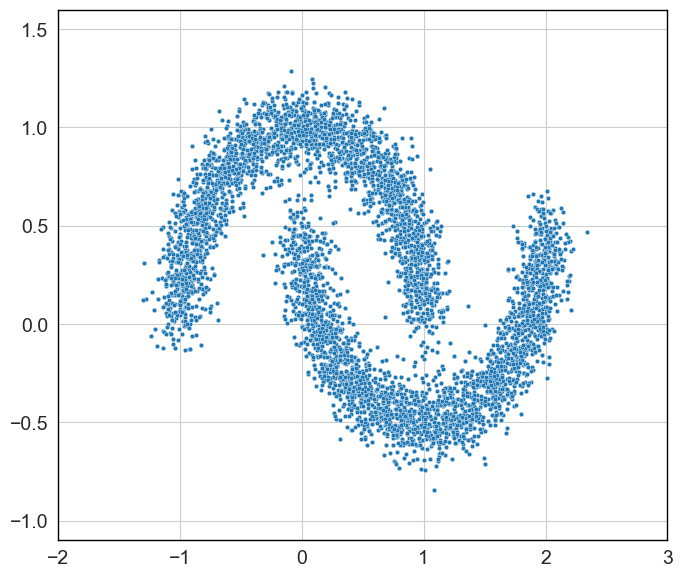

In [ ]:
g = sns.relplot(data=pd.DataFrame(data), x=0, y=1, kind='scatter', s=11, height=6, aspect=7/6)
g.set(xlim=(-2, 3), ylim=(-1.1, 1.6))
plt.tick_params(labelsize=14); plt.xlabel(None); plt.ylabel(None)
ax = g.ax
# 枠（spines）の色と太さを変更
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_edgecolor('k')
    ax.spines[spine].set_linewidth(1) 

# Apply QMEM

In [5]:
theta_set = (lambda a_min, a_max, K: np.linspace(a_min, a_max, K + 1)[:-1] + (a_max - a_min) / (2 * K))(-np.pi/2, np.pi/2, 25)
axes_data = np.array([[np.cos(theta), np.sin(theta)] for theta in theta_set])
qs = np.linspace(0.03, 0.97, 25)
pj_data = np.array([qmem.quantile(data @ np.array([np.cos(theta), np.sin(theta)]), 
                                  q=qs, weight=np.ones(data.shape[0]))
                    for theta in theta_set]).T

In [6]:
pj_data.shape

(25, 25)

In [122]:
%%time
h_ = qmem.QMEM(n_base=150, seed=24, n_ensemble=20, qs=qs, pj_data=pj_data, directions=axes_data)

Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 2456, selection rate: 81.9 %
CPU times: total: 42.7 s
Wall time: 43.1 s


In [10]:
def moons_plotter(data: np.ndarray, hist: list, idx: int):
    
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.kdeplot(data=pd.DataFrame(data), x=0, y=1, fill=True, cmap='Blues', alpha=0.75, ax=ax, levels=30, thresh=0.05, bw_adjust=0.5)

    sns.scatterplot(data=pd.DataFrame(hist[idx][1]), x=0, y=1, s=75,
                    color=[(1, 0, 0, a) for a in hist[idx][0]/np.max(hist[idx][0])], edgecolor='r', ax=ax)

    ED = qmem.energy_distance(X=data, weight_X=None, Y=hist[idx][1], weight_Y=hist[idx][0])

    ax.text(1., 1.3, f'ED = {ED:.3f}', fontsize=28, color='k')
    plt.tight_layout()
    plt.xlim(-2, 3); plt.ylim(-1.1, 1.6)
    plt.tick_params(labelsize=16); plt.xlabel(None); plt.ylabel(None)

    # 枠（spines）の色と太さを変更
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_edgecolor('k')
        ax.spines[spine].set_linewidth(1) 
        
    plt.show()

    return ED

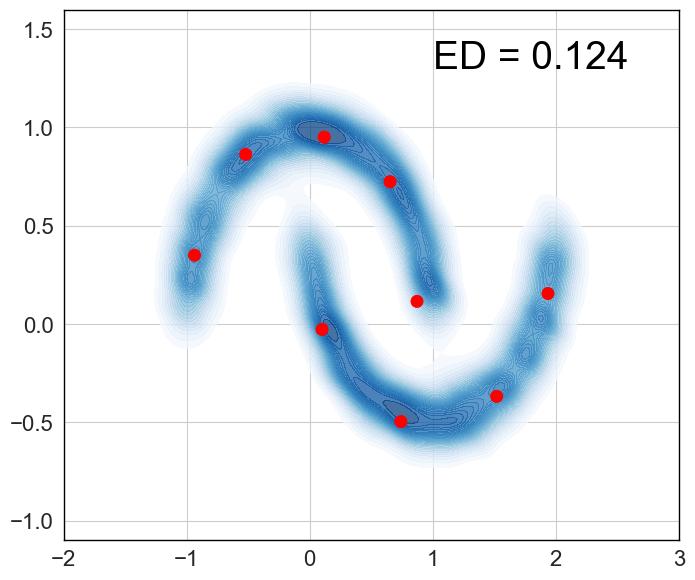

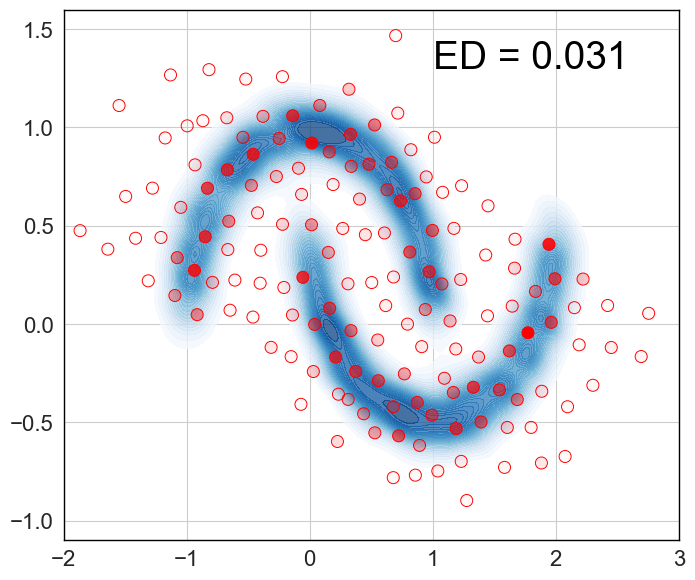

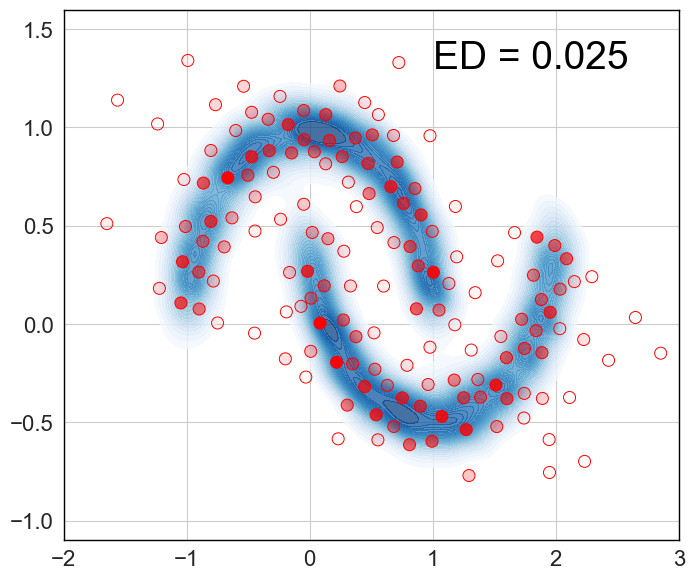

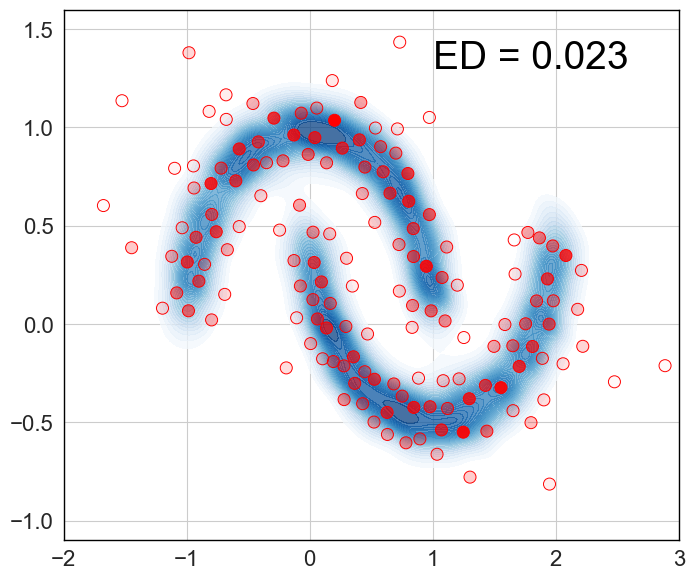

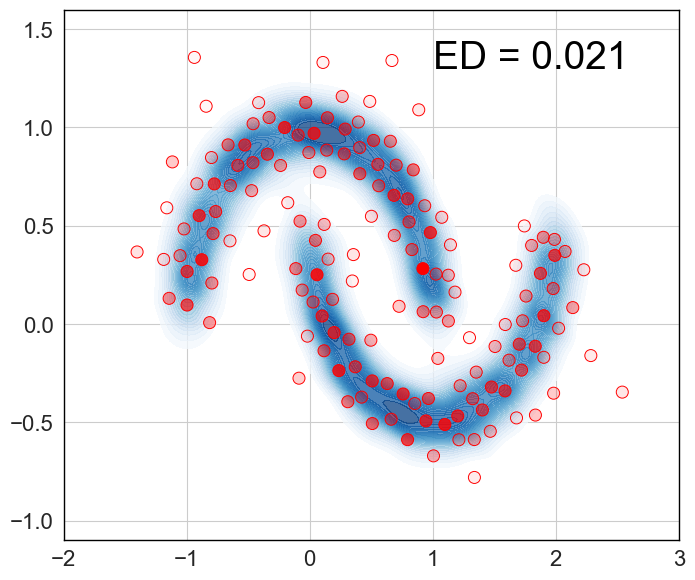

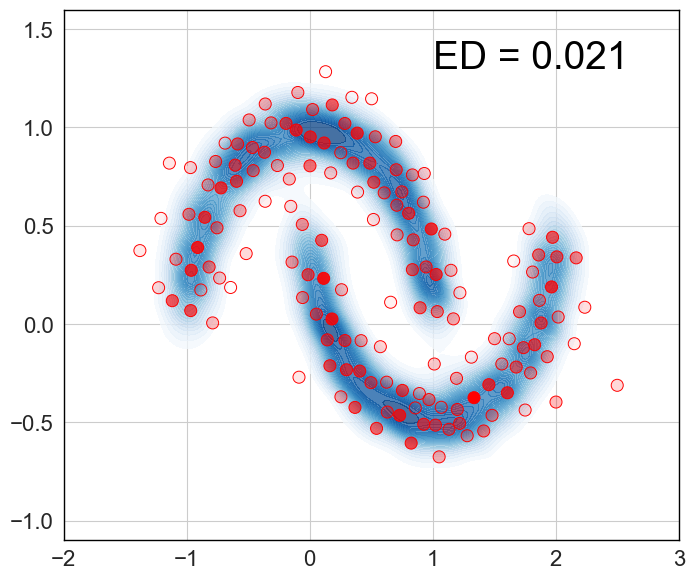

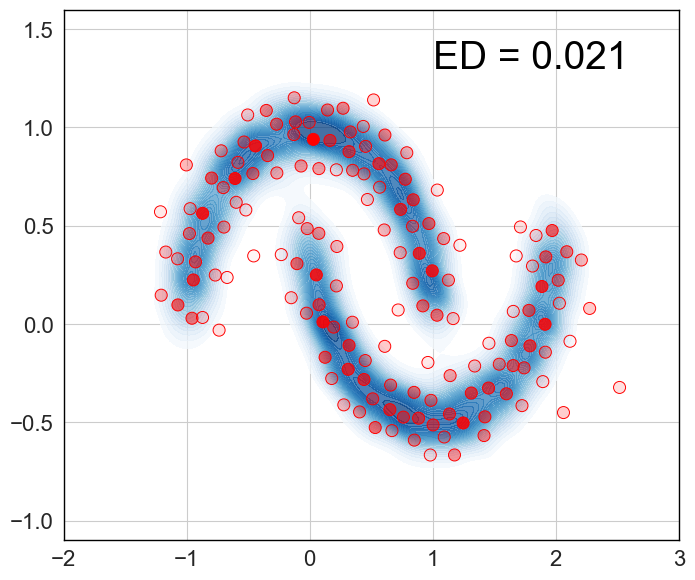

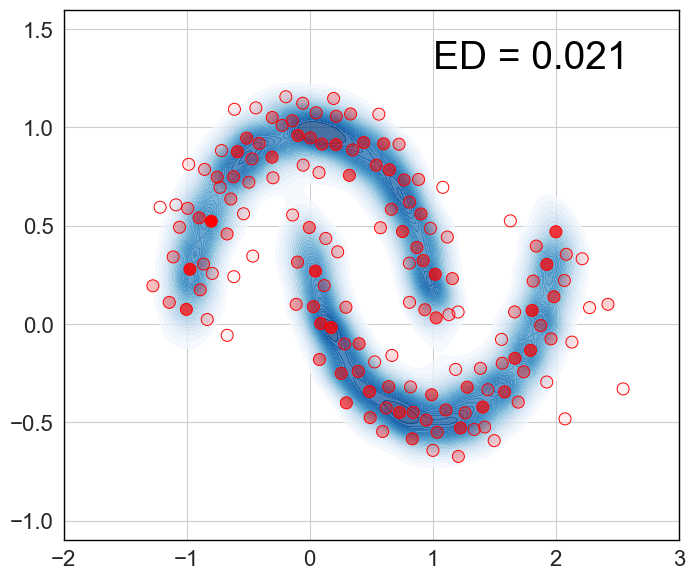

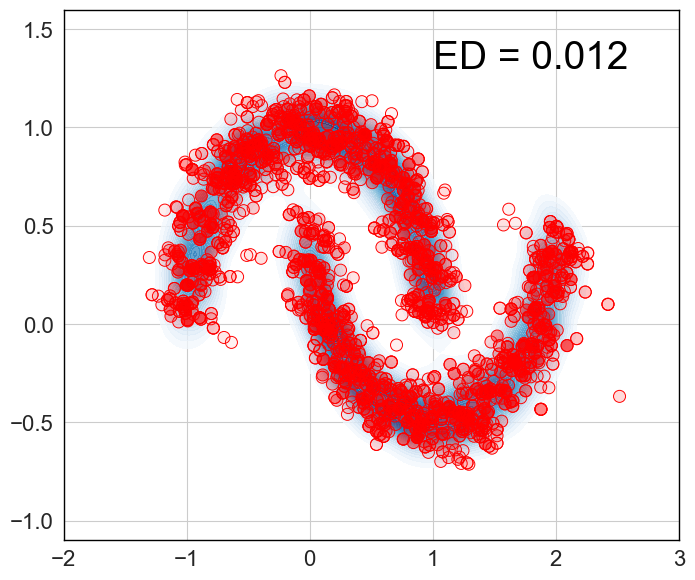

In [124]:
for i in range(len(h_)):
    moons_plotter(data=data, hist=h_, idx=i)

In [12]:
def qmem_param_changer(data: np.ndarray, K: int, M: int, seed: int):

    theta_set = (lambda a_min, a_max, K: np.linspace(a_min, a_max, K + 1)[:-1] + (a_max - a_min) / (2 * K))(-np.pi/2, np.pi/2, K)
    axes_data = np.array([[np.cos(theta), np.sin(theta)] for theta in theta_set])
    qs = np.linspace(0.03, 0.97, M)
    pj_data = np.array([qmem.quantile(data @ np.array([np.cos(theta), np.sin(theta)]), 
                                      q=qs, weight=np.ones(data.shape[0]))
                        for theta in theta_set]).T
    
    h_ = qmem.QMEM(n_base=150, seed=seed, n_ensemble=20, qs=qs, pj_data=pj_data, directions=axes_data, n_jobs=7)
    idx = -1
    ED = qmem.energy_distance(X=data, weight_X=None, Y=h_[idx][1], weight_Y=h_[idx][0])

    return ED

In [13]:
%%time
out_all = np.zeros((3, 25, 3))

for seed in range(3):

    out = []
    for K in [5, 10, 15, 20, 25]:
        print(f'K = {K}')
        for M in [5, 10, 15, 20, 25]:
            print(f'{M}', end=' ')
            out += [[K, M, qmem_param_changer(data=data, K=K, M=M, seed=seed)]]
            print('')
    
    out = np.array(out)
    out_all[seed] = out

K = 5
5 Initial search done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 1111, selection rate: 37.0 %

10 Initial search done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 2551, selection rate: 85.0 %

15 Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 2206, selection rate: 73.5 %

20 Initial search done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 1616, selection rate: 53.9 %

25 Initial search done.
Optimization done.
Optimization d

In [16]:
out_all.shape

(3, 25, 3)

In [ ]:
# np.save('qmem_K_M_out_all', out_all)

In [21]:
out_mean = np.mean(out_all, axis=0)
out_mean

array([[ 5.        ,  5.        ,  0.06969869],
       [ 5.        , 10.        ,  0.0312463 ],
       [ 5.        , 15.        ,  0.02599574],
       [ 5.        , 20.        ,  0.02335619],
       [ 5.        , 25.        ,  0.02080466],
       [10.        ,  5.        ,  0.05037421],
       [10.        , 10.        ,  0.02095182],
       [10.        , 15.        ,  0.01784737],
       [10.        , 20.        ,  0.01495832],
       [10.        , 25.        ,  0.01363196],
       [15.        ,  5.        ,  0.04783478],
       [15.        , 10.        ,  0.01827337],
       [15.        , 15.        ,  0.01541981],
       [15.        , 20.        ,  0.01229993],
       [15.        , 25.        ,  0.01284416],
       [20.        ,  5.        ,  0.0497422 ],
       [20.        , 10.        ,  0.01918685],
       [20.        , 15.        ,  0.01350544],
       [20.        , 20.        ,  0.01244046],
       [20.        , 25.        ,  0.01168255],
       [25.        ,  5.        ,  0.054

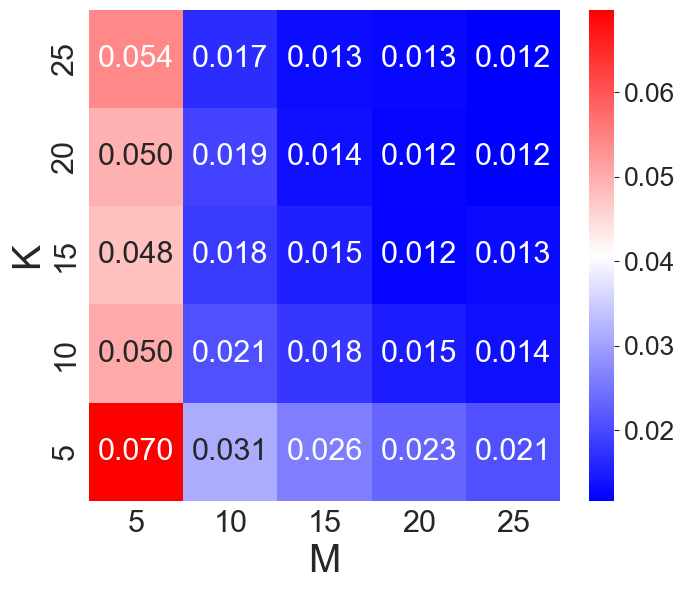

In [ ]:
x = np.unique(out_mean[:, 0]).astype(int)
y = np.unique(out_mean[:, 1]).astype(int)
z = out_mean[:, 2].reshape(len(x), len(y))

df = pd.DataFrame(z, index=x, columns=y)
df.index.name = 'K'
df.columns.name = 'M'

plt.figure(figsize=(7, 6))
ax = sns.heatmap(df, annot=True, fmt=".3f", cmap="bwr", annot_kws={"fontsize": 22})
ax.invert_yaxis()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=19)
plt.tick_params(labelsize=22); plt.xlabel("M", fontsize=28); plt.ylabel("K", fontsize=28)
plt.tight_layout()
plt.show()

In [24]:
def plot_helper(data: np.ndarray, K: int, M: int, seed: int):

    theta_set = (lambda a_min, a_max, K: np.linspace(a_min, a_max, K + 1)[:-1] + (a_max - a_min) / (2 * K))(-np.pi/2, np.pi/2, K)
    axes_data = np.array([[np.cos(theta), np.sin(theta)] for theta in theta_set])
    qs = np.linspace(0.03, 0.97, M)
    pj_data = np.array([qmem.quantile(data @ np.array([np.cos(theta), np.sin(theta)]), 
                                      q=qs, weight=np.ones(data.shape[0]))
                        for theta in theta_set]).T
    
    h_ = qmem.QMEM(n_base=150, seed=seed, n_ensemble=20, qs=qs, pj_data=pj_data, directions=axes_data, n_jobs=4)
    moons_plotter(data=data, hist=h_, idx=-1)

Initial search done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 1051, selection rate: 35.0 %


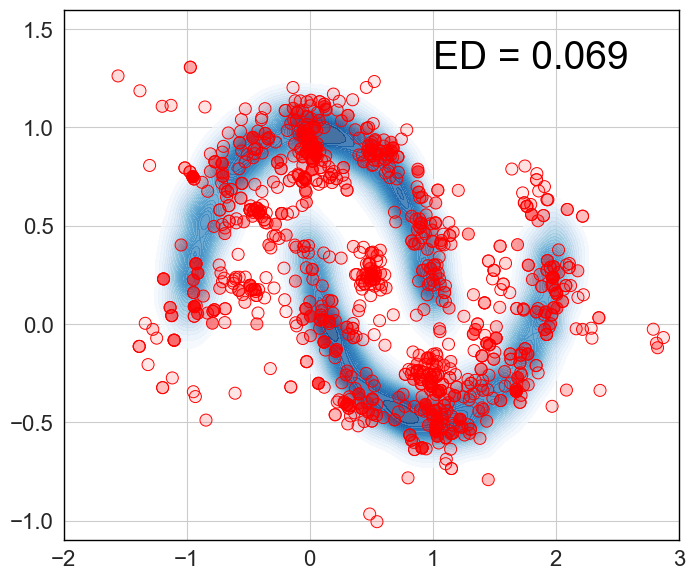

In [25]:
plot_helper(data=data, K=5, M=5, seed=0)

Check sensitivity to ensemble size

In [10]:
%%time
h_all = [[qmem.QMEM(n_base=150, seed=seed, n_ensemble=E, n_jobs=1 if E == 1 else 2 if E <= 6 else 3, 
          qs=qs, pj_data=pj_data, directions=axes_data) for E in [1, 2, 3, 4, 6, 8, 10, 13, 16, 20]]
         for seed in range(3)]

Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 150, selection rate: 100.0 %
Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 300, selection rate: 100.0 %
Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 420, selection rate: 93.3 %
Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support po

In [ ]:
# import dill
# with open('h_all_varying_ensemble_size.pkl', 'wb') as f:
#     dill.dump(h_all, f)

In [18]:
%%time
res = np.zeros((3, 10))

for idx_seed in range(3):
    
    res[idx_seed] = [(lambda ws, pts: qmem.energy_distance(X=data, weight_X=None, Y=pts, weight_Y=ws))(h[-1][0], h[-1][1])
         for h in h_all[idx_seed]]

CPU times: total: 8min 1s
Wall time: 8min 38s


In [19]:
res

array([[0.02855681, 0.02267544, 0.0196018 , 0.01777818, 0.015967  ,
        0.01403738, 0.01314381, 0.01207049, 0.0115664 , 0.01114586],
       [0.02863808, 0.02183431, 0.01899535, 0.01798076, 0.01590426,
        0.01463762, 0.01371549, 0.0130612 , 0.01279752, 0.01257172],
       [0.02867244, 0.02124502, 0.01908027, 0.01758402, 0.01501822,
        0.01369463, 0.01278151, 0.01225014, 0.01202223, 0.01169917]])

In [61]:
np.mean(res, axis=0)

array([0.02862245, 0.02191826, 0.01922581, 0.01778099, 0.01562983,
       0.01412321, 0.0132136 , 0.01246061, 0.01212871, 0.01180558])

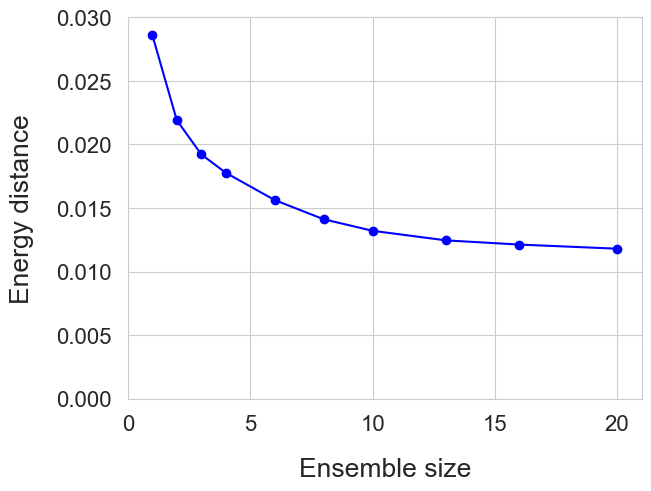

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax.set_xlim(0, 21)
ax.set_ylim(0., 0.03)

ax.plot([1,2,3,4,6,8,10,13,16,20], np.mean(res, axis=0), 'o-', c='b')

ax.set_xlabel('Ensemble size', fontsize=19, labelpad=16)    # spacing between label and axis
ax.set_ylabel('Energy distance', fontsize=19, labelpad=16)
ax.tick_params(labelsize=16, pad=8) 

In [ ]:
%%time
data, _ = make_moons(n_samples=5000, random_state=874, noise=0.1)
eds = []

for seed in range(20):
    eds += [qmem.energy_distance(X=data, weight_X=None, 
                                 Y=make_moons(n_samples=2456, random_state=seed, noise=0.1)[0], weight_Y=None)]

In [9]:
eds

[0.01021278700662979,
 0.010282793299285798,
 0.009807428830303258,
 0.011826740602346206,
 0.011205978903490248,
 0.010663098672807505,
 0.009870887047900734,
 0.01109609110598985,
 0.01111684060609504,
 0.009990220645447698,
 0.009776427008627056,
 0.010592037170633749,
 0.008850010345859492,
 0.010845158952855033,
 0.010114402943867833,
 0.010185477976502755,
 0.009166099361659578,
 0.009315581281581692,
 0.010521362373968064,
 0.01036705770743583]

In [11]:
np.mean(eds), np.std(eds)

(np.float64(0.01029032409216436), np.float64(0.0007151319910226665))

# Character Data 1

In [4]:
from src.gendata import create_character_data

In [58]:
data = create_character_data('A')
data.shape

(2029, 2)

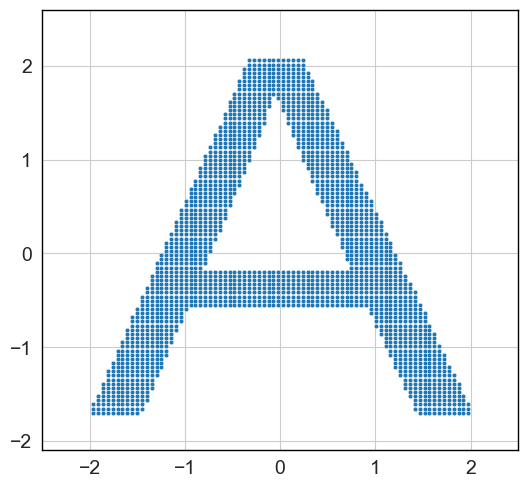

In [ ]:
g = sns.relplot(data=pd.DataFrame(data), x=0, y=1, kind='scatter', s=10, height=5.1, aspect=1.1)
g.set(xlim=(-2.5, 2.5), ylim=(-2.1, 2.6))
plt.tick_params(labelsize=14); plt.xlabel(None); plt.ylabel(None)
ax = g.ax

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_edgecolor('k')
    ax.spines[spine].set_linewidth(1) 

# Apply QMEM

In [105]:
theta_set = (lambda a_min, a_max, K: np.linspace(a_min, a_max, K + 1)[:-1] + (a_max - a_min) / (2 * K))(-np.pi/2, np.pi/2, 25)
axes_data = np.array([[np.cos(theta), np.sin(theta)] for theta in theta_set])
qs = np.linspace(0.03, 0.97, 25)
pj_data = np.array([qmem.quantile(data @ np.array([np.cos(theta), np.sin(theta)]), 
                                  q=qs, weight=np.ones(data.shape[0]))
                    for theta in theta_set]).T

In [106]:
%%time
h_ = qmem.QMEM(n_base=150, seed=0, n_ensemble=20, qs=qs, pj_data=pj_data, directions=axes_data)

Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 2570, selection rate: 85.7 %
CPU times: total: 1min 36s
Wall time: 1min 37s


In [ ]:
def moons_plotter(data: np.ndarray, hist: list, idx: int):
    
    fig, ax = plt.subplots(figsize=(5.5, 5))
    sns.kdeplot(data=pd.DataFrame(data), x=0, y=1, fill=True, cmap='Blues', alpha=0.75, ax=ax, levels=30, thresh=0.05, bw_adjust=0.5)

    sns.scatterplot(data=pd.DataFrame(hist[idx][1]), x=0, y=1, s=75,
                    color=[(1, 0, 0, a) for a in hist[idx][0]/np.max(hist[idx][0])], edgecolor='r', ax=ax)

    ED = qmem.energy_distance(X=data, weight_X=None, Y=hist[idx][1], weight_Y=hist[idx][0])

    ax.text(0.8, 2.25, f'ED = {ED:.3f}', fontsize=22, color='k')
    plt.tight_layout()
    plt.xlim(-2.7, 2.7); plt.ylim(-2.3, 2.6)
    plt.tick_params(labelsize=16); plt.xlabel(None); plt.ylabel(None)

    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_edgecolor('k')
        ax.spines[spine].set_linewidth(1) 
        
    plt.show()

    return ED

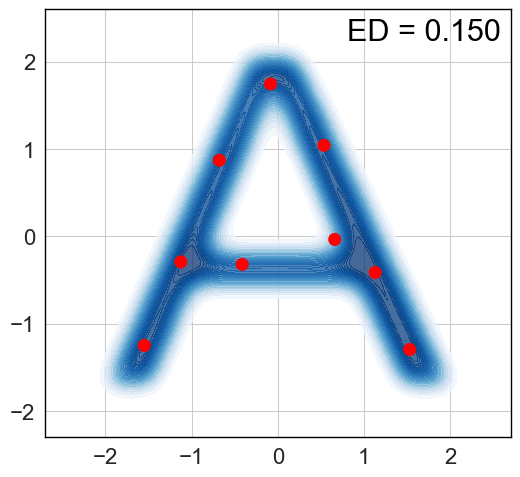

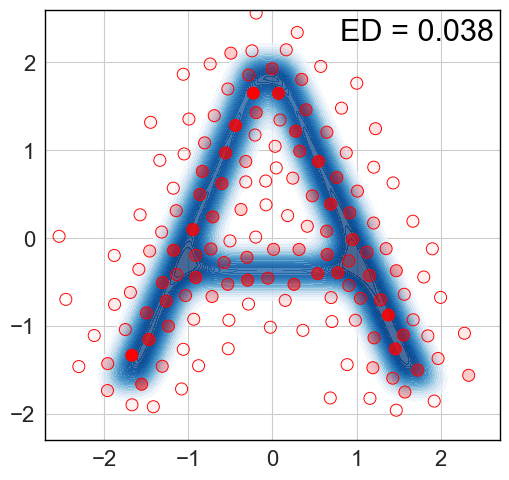

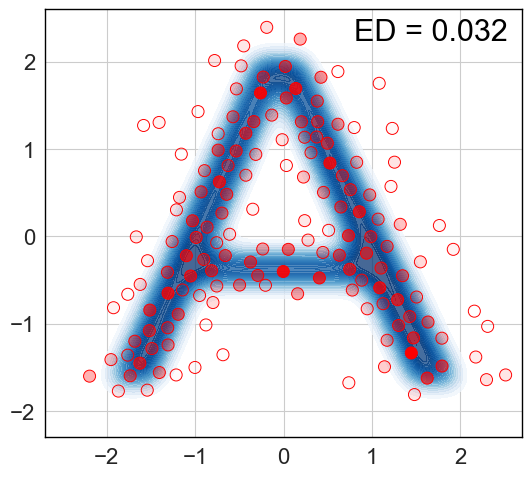

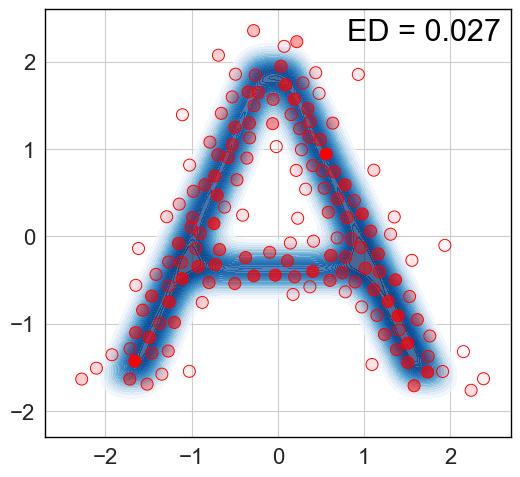

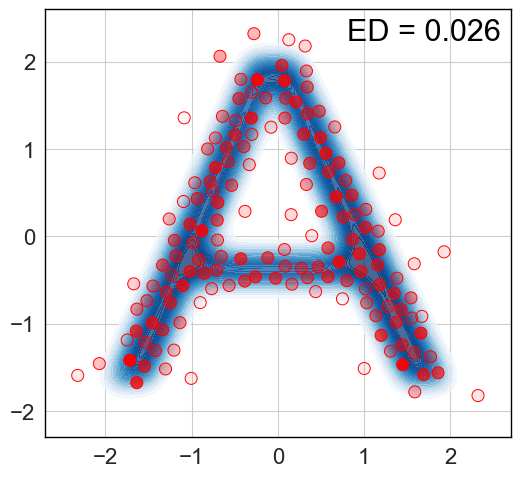

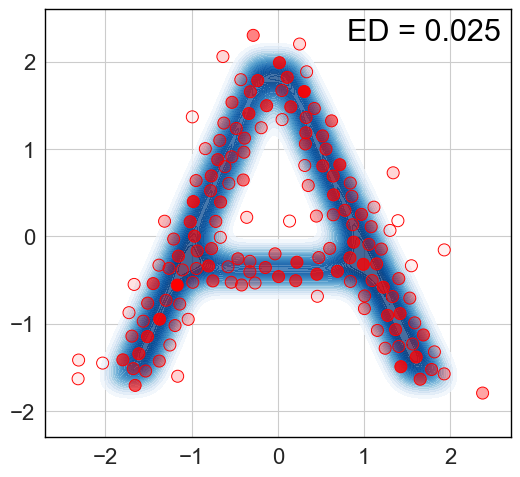

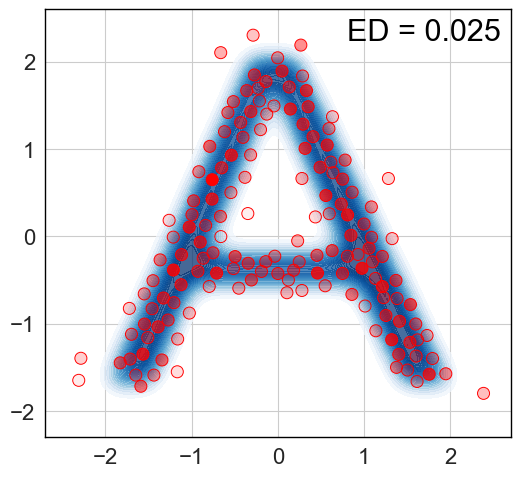

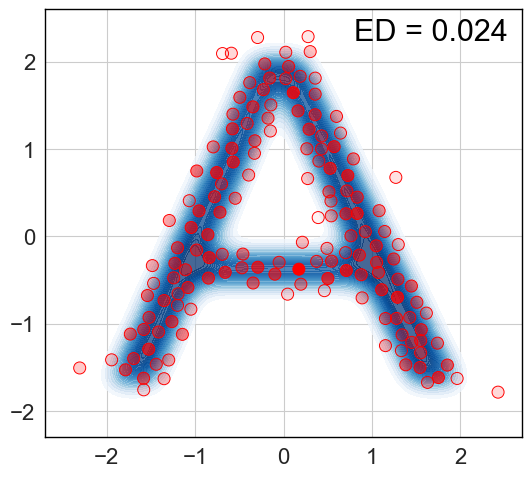

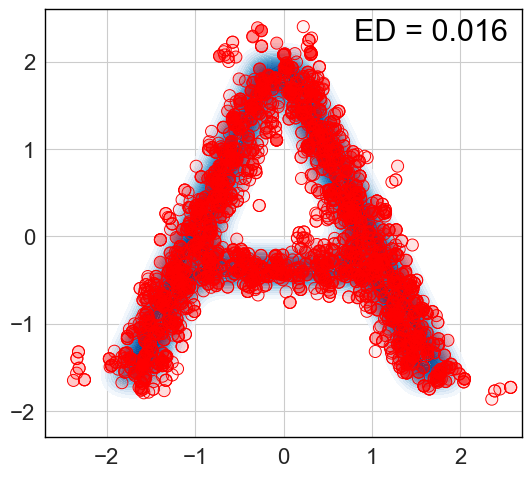

In [109]:
for i in range(len(h_)):
    moons_plotter(data=data, hist=h_, idx=i)  

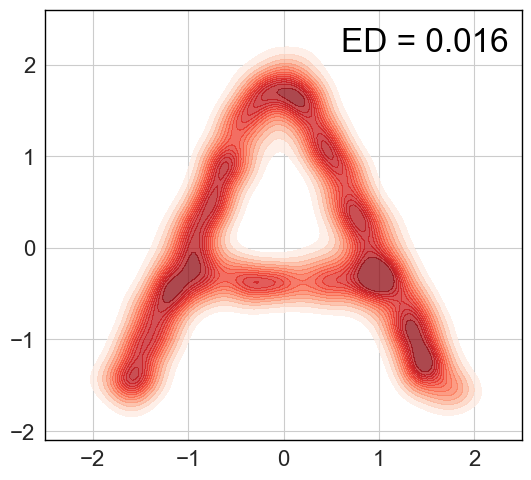

In [ ]:
fig, ax = plt.subplots(figsize=(5.5, 5))
sns.kdeplot(data=pd.DataFrame(h_[-1][1]), weights=h_[-1][0],
            x=0, y=1, fill=True, cmap='Reds', alpha=0.75, ax=ax, levels=15, thresh=0.1, bw_adjust=0.6)

ED = qmem.energy_distance(X=data, weight_X=None, Y=h_[-1][1], weight_Y=h_[-1][0])
ax.text(0.6, 2.14, f'ED = {ED:.3f}', fontsize=24, color='k')
plt.tight_layout()
plt.xlim(-2.5, 2.5); plt.ylim(-2.1, 2.6)
plt.tick_params(labelsize=16); plt.xlabel(None); plt.ylabel(None)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_edgecolor('k')
    ax.spines[spine].set_linewidth(1) 
    
plt.show()

# Character Data 2

In [221]:
data = create_character_data('P')
data.shape

(2059, 2)

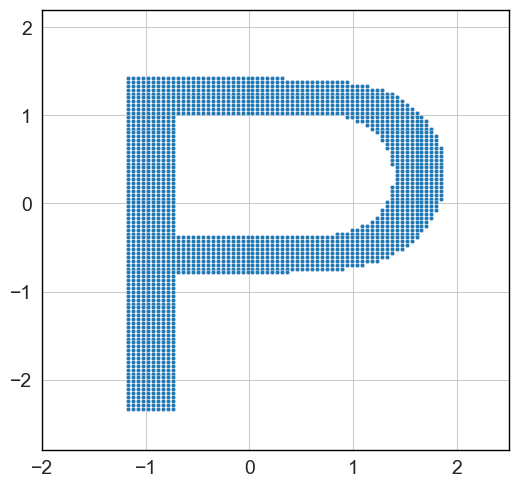

In [ ]:
g = sns.relplot(data=pd.DataFrame(data), x=0, y=1, kind='scatter', s=10, height=5.1, aspect=1.1)
g.set(xlim=(-2., 2.5), ylim=(-2.8, 2.2))
plt.tick_params(labelsize=14); plt.xlabel(None); plt.ylabel(None)
ax = g.ax

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_edgecolor('k')
    ax.spines[spine].set_linewidth(1) 

# Apply QMEM

In [223]:
theta_set = (lambda a_min, a_max, K: np.linspace(a_min, a_max, K + 1)[:-1] + (a_max - a_min) / (2 * K))(-np.pi/2, np.pi/2, 25)
axes_data = np.array([[np.cos(theta), np.sin(theta)] for theta in theta_set])
qs = np.linspace(0.03, 0.97, 25)
pj_data = np.array([qmem.quantile(data @ np.array([np.cos(theta), np.sin(theta)]), 
                                  q=qs, weight=np.ones(data.shape[0]))
                    for theta in theta_set]).T

In [224]:
%%time
h_ = qmem.QMEM(n_base=150, seed=0, n_ensemble=20, qs=qs, pj_data=pj_data, directions=axes_data)

Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 2785, selection rate: 92.8 %
CPU times: total: 1min 12s
Wall time: 1min 12s


In [ ]:
def moons_plotter(data: np.ndarray, hist: list, idx: int):
    
    fig, ax = plt.subplots(figsize=(5.5, 5))
    sns.kdeplot(data=pd.DataFrame(data), x=0, y=1, fill=True, cmap='Blues', 
                alpha=0.75, ax=ax, levels=30, thresh=0.05, bw_adjust=0.5)

    sns.scatterplot(data=pd.DataFrame(hist[idx][1]), x=0, y=1, s=75,
                    color=[(1, 0, 0, a) for a in hist[idx][0]/np.max(hist[idx][0])], edgecolor='r', ax=ax)

    ED = qmem.energy_distance(X=data, weight_X=None, Y=hist[idx][1], weight_Y=hist[idx][0])
    ax.text(0.6, -2.2, f'ED = {ED:.3f}', fontsize=22, color='k')
    
    plt.tight_layout()
    plt.xlim(-2., 2.5); plt.ylim(-2.8, 2.2)
    plt.tick_params(labelsize=16); plt.xlabel(None); plt.ylabel(None)

    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_edgecolor('k')
        ax.spines[spine].set_linewidth(1) 
        
    plt.show()

    return ED

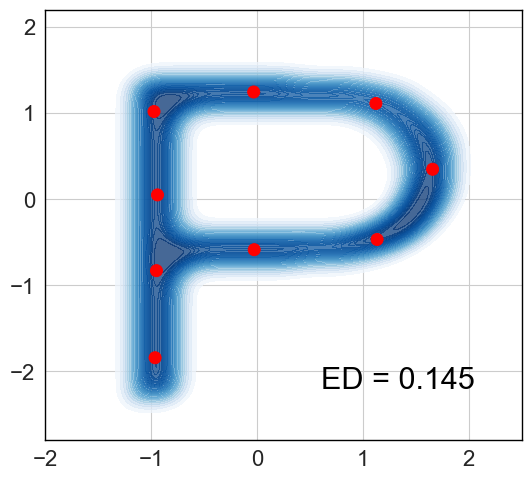

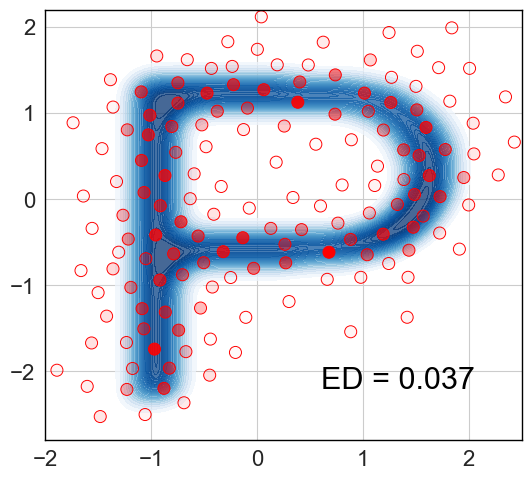

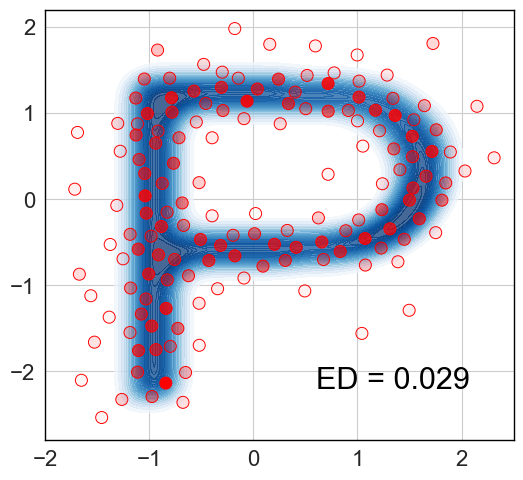

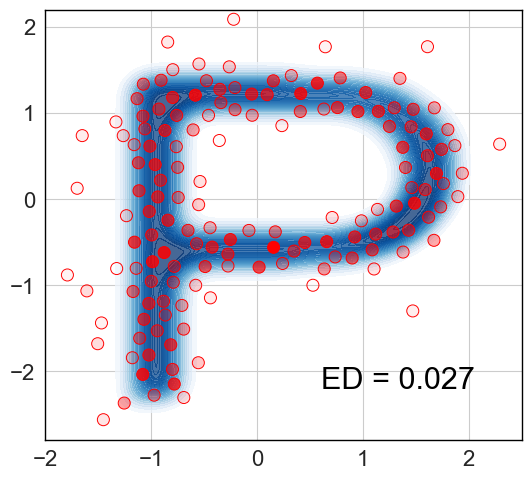

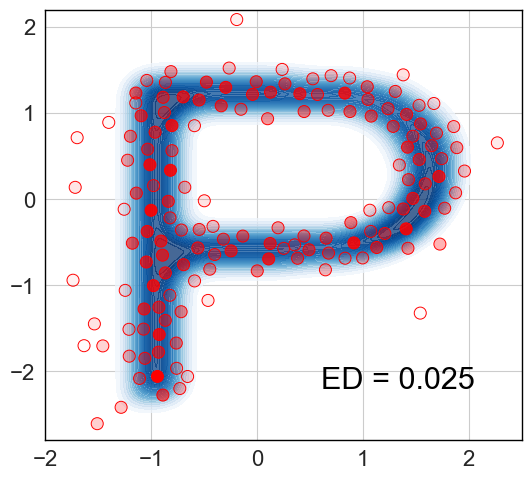

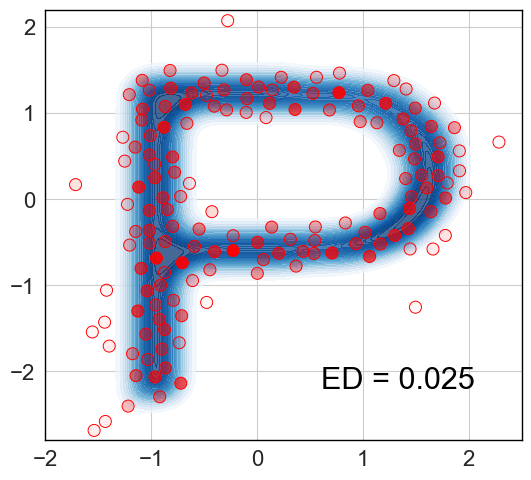

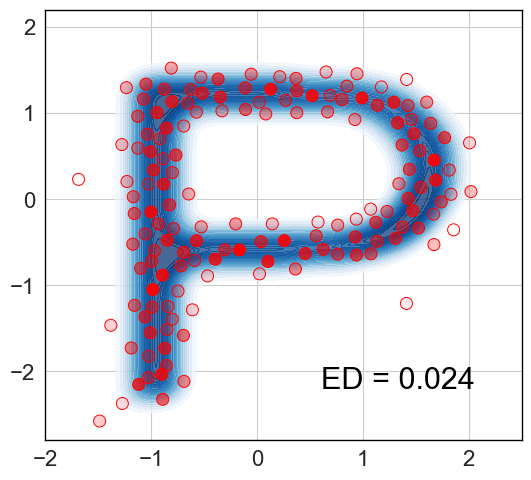

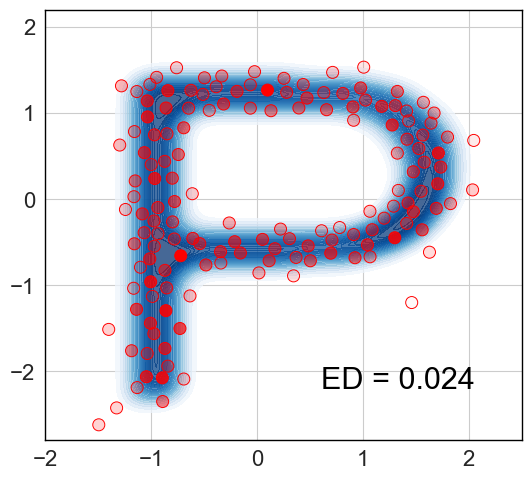

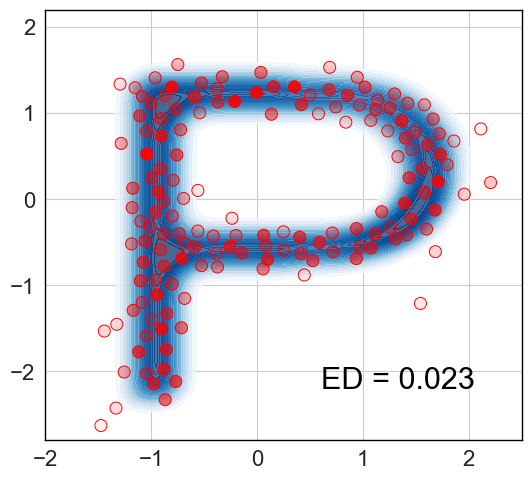

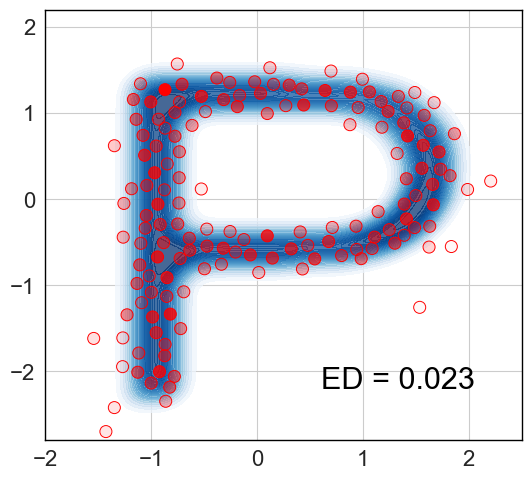

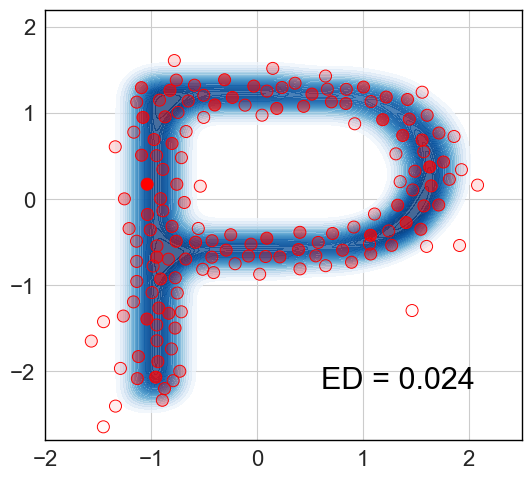

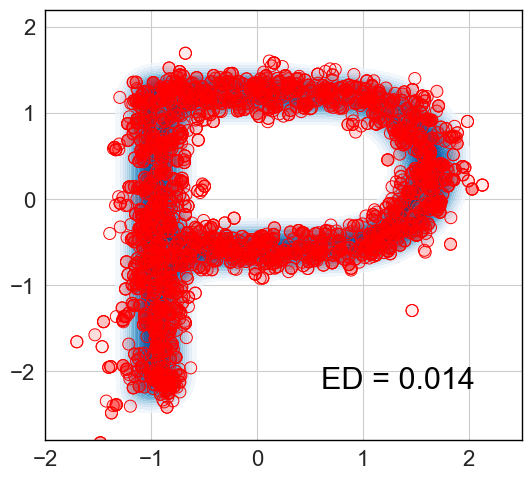

In [235]:
for i in range(len(h_)):
    moons_plotter(data=data, hist=h_, idx=i)  

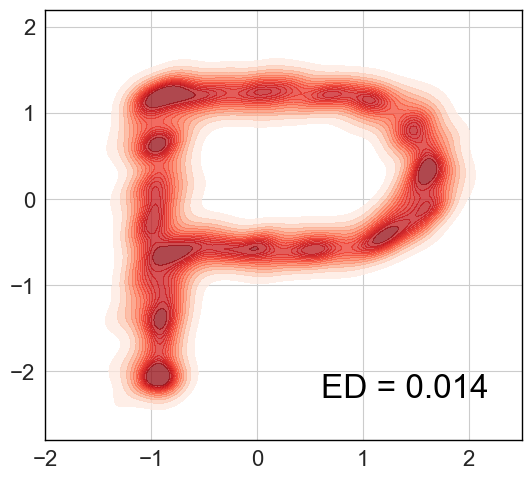

In [ ]:
fig, ax = plt.subplots(figsize=(5.5, 5))
sns.kdeplot(data=pd.DataFrame(h_[-1][1]), weights=h_[-1][0],
            x=0, y=1, fill=True, cmap='Reds', alpha=0.75, ax=ax, levels=15, thresh=0.05, 
            bw_adjust=0.5)

ED = qmem.energy_distance(X=data, weight_X=None, Y=h_[-1][1], weight_Y=h_[-1][0])
ax.text(0.6, -2.3, f'ED = {ED:.3f}', fontsize=24, color='k')
plt.tight_layout()
plt.xlim(-2., 2.5); plt.ylim(-2.8, 2.2)
plt.tick_params(labelsize=16); plt.xlabel(None); plt.ylabel(None)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_edgecolor('k')
    ax.spines[spine].set_linewidth(1) 
    
plt.show()